# Personal Information
Name: **Ray Ren**

StudentID: **15086305**

Email: [**rensongyursy@outlook.com**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context
**In this project, we explore time series analysis through the lens of stock market data, with a particular focus on the S&P 500 index. We start by scraping Wikipedia to obtain the component tickers of the 500 companies that make up the index, directing our primary analysis towards Apple Inc. (AAPL) due to its significant market influence and data availability. Employing Long Short-Term Memory (LSTM) networks—a type of Recurrent Neural Network tailored for sequential data—we benchmark our analysis on AAPL stock. This methodology not only leverages LSTM's capability to capture complex patterns in time series data but also aims to offer insights into the stock's future price movements, showcasing the project's blend of financial analysis and machine learning techniques.**

In [2]:
# Imports
import math
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
# from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import requests
# import quandl

### Scrap the data

In [4]:
# Function to get the list of current S&P 500 companies from Wikipedia
def get_sp500_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500_df = table[0]
    tickers = sp500_df['Symbol'].tolist()
    # Adjusting tickers for compatibility (replacing '.' with '-')
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    return tickers

# Get the list of tickers
sp500_tickers = get_sp500_tickers()

# Convert the list to a DataFrame and save it as a CSV file
sp500_tickers_df = pd.DataFrame(sp500_tickers, columns=['Ticker'])
csv_file_path = './trail/sp500_tickers.csv'
sp500_tickers_df.to_csv(csv_file_path, index=False)

### Retrieval data from Yahoo finance

In [ ]:
import yfinance as yf
import os

# Function to read tickers from a file
def read_tickers(file_path):
    with open(file_path, 'r') as file:
        tickers = [line.strip() for line in file.readlines()]
    return tickers

# Define the path to the tickers file and output folder
tickers_file_path = './data/sp500_tickers.txt'
output_folder = 'stock_data_yf_new'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read the list of tickers
tickers = read_tickers(tickers_file_path)

# Retrieve and save data for each ticker
for ticker in tickers:
    print(f"Retrieving data for {ticker}")
    ticker_data = yf.Ticker(ticker)
    ticker_df = ticker_data.history(period='max', interval='1d')

    # Save the data to a CSV file
    output_file_path = os.path.join(output_folder, f"{ticker}.csv")
    ticker_df.to_csv(output_file_path)

print("Data retrieval complete.")


In [ ]:
# Define the paths
folder_path = 'stock_data_yf_new'
tickers_file_path = './data/sp500_tickers.txt'

# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Function to count the number of lines in a file
def count_lines_in_file(file_path):
    with open(file_path, 'r') as file:
        return sum(1 for line in file)

# Count the files in the directory
num_files = count_files_in_directory(folder_path)
print(f"Number of files in '{folder_path}': {num_files}")

# Count the lines in the tickers file
num_lines = count_lines_in_file(tickers_file_path)
print(f"Number of lines in '{tickers_file_path}': {num_lines}")

### Prediction for one Stock

#### Using LSTM

In [1]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import math
import torch.optim as optim
import json
import os

In [2]:
data = pd.read_csv('./AAPL_full_history_stock_data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)  # Convert to UTC datetime

In [3]:
# Descriptive Statistics
print("Descriptive Statistics:")
print(data.describe())

Descriptive Statistics:
               Open          High           Low         Close        Volume  \
count  10866.000000  10866.000000  10866.000000  10866.000000  1.086600e+04   
mean      19.504953     19.718402     19.300929     19.519398  3.211700e+08   
std       41.911321     42.372891     41.483187     41.952305  3.362876e+08   
min        0.038432      0.038432      0.038000      0.038000  0.000000e+00   
25%        0.240682      0.245827      0.235223      0.241682  1.158186e+08   
50%        0.417847      0.425808      0.412336      0.419140  2.086980e+08   
75%       16.533206     16.722123     16.400521     16.533899  4.011098e+08   
max      198.020004    199.619995    197.000000    198.110001  7.421641e+09   

          Dividends  Stock Splits  
count  10866.000000  10866.000000  
mean       0.000716      0.001565  
std        0.011350      0.084170  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0

Text(0.5, 1.0, 'Histogram of Opening Prices')

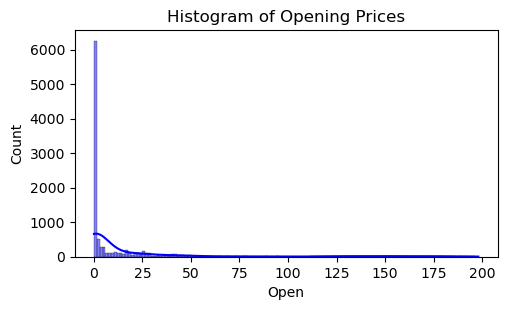

In [4]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
sns.histplot(data['Open'], kde=True, color='blue')
plt.title('Histogram of Opening Prices')

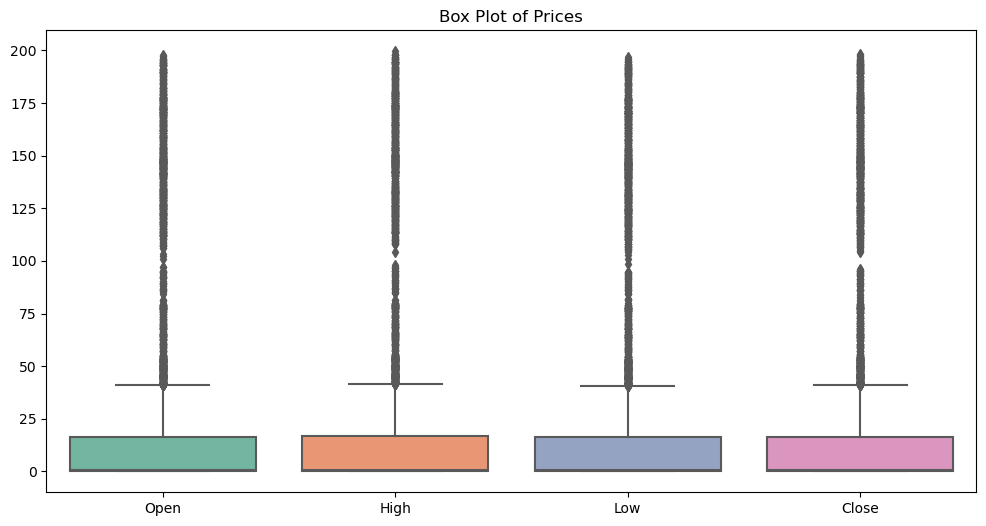

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Open', 'High', 'Low', 'Close']], palette='Set2')
plt.title('Box Plot of Prices')
plt.show()

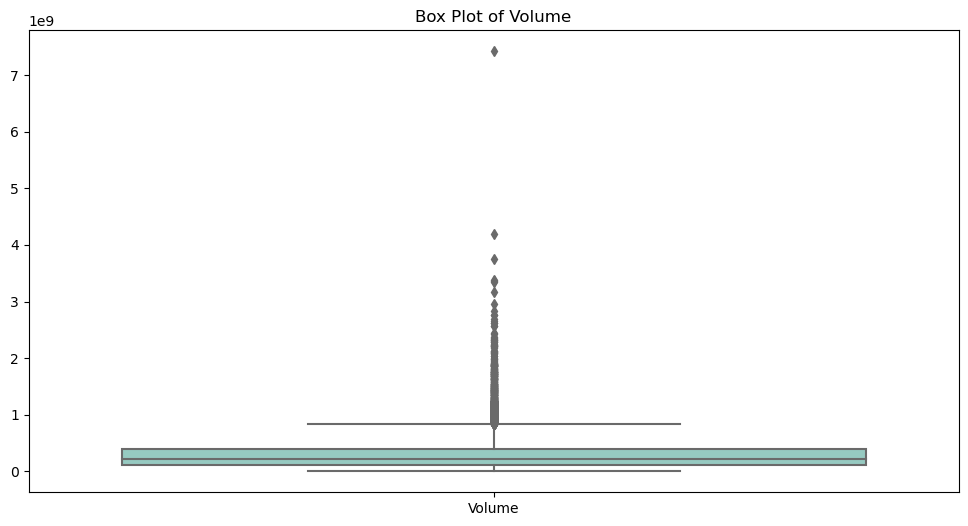

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[['Volume']], palette='Set3')
plt.title('Box Plot of Volume')
plt.show()

In [7]:
# Filter the DataFrame to only include dates after 1988-01-01
df_filtered = data[data.index > pd.Timestamp('2008-01-01', tz='UTC')]

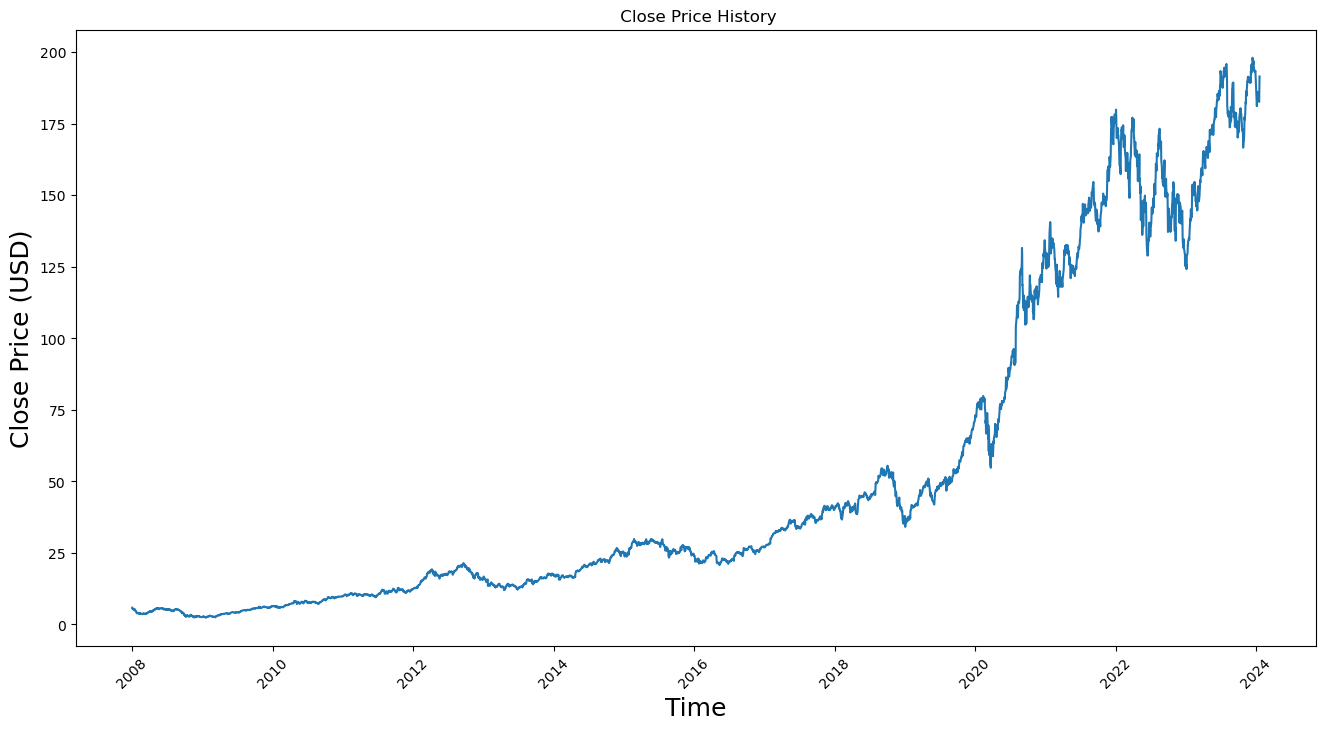

In [8]:
plt.figure(figsize=(16,8))
plt.title(" Close Price History")
plt.plot(df_filtered['Close'])
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Set the locator for the major axis
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))  # Use ConciseDateFormatter for a cleaner look
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()

In [9]:
# Load and prepare data
df_filtered = df_filtered.filter(['Close'])
dataset = df_filtered.values


In [10]:
# Scaling function to normalize the dataset
def min_max_scaler(tensor, feature_range=(0, 1)):
    min_val = tensor.min()
    max_val = tensor.max()
    scale = feature_range[1] - feature_range[0]
    std = (tensor - min_val) / (max_val - min_val)
    return std * scale + feature_range[0]

In [11]:
# Convert dataset to a PyTorch tensor
dataset_tensor = torch.FloatTensor(dataset)
scaled_dataset = min_max_scaler(dataset_tensor)

In [12]:
# Create input/output sequences for LSTM
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return torch.stack([s[0] for s in inout_seq]), torch.cat([s[1] for s in inout_seq])


In [13]:
sequence_length = 50
X, y = create_inout_sequences(scaled_dataset.squeeze(), sequence_length)
X = X.unsqueeze(-1)  # Adding a channel dimension


In [14]:
# Split data chronologically for an 80/20 train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [15]:
# Data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


In [17]:
# Initialize model, loss, and optimizer
model = LSTMModel(input_size=1, hidden_size=10, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Users/songyuren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [19]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_losses = [criterion(model(X_batch), y_batch).item() for X_batch, y_batch in test_loader]
    
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {np.mean(test_losses):.4f}')


Epoch 1/10, Test Loss: 0.1277
Epoch 2/10, Test Loss: 0.0895
Epoch 3/10, Test Loss: 0.0651
Epoch 4/10, Test Loss: 0.0509
Epoch 5/10, Test Loss: 0.0431
Epoch 6/10, Test Loss: 0.0374
Epoch 7/10, Test Loss: 0.0334
Epoch 8/10, Test Loss: 0.0304
Epoch 9/10, Test Loss: 0.0282
Epoch 10/10, Test Loss: 0.0265


In [51]:
def test_metrics(model, loader, criterion):
    model.eval()
    targets = []
    outputs = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            output = model(X_batch)
            outputs.extend(output.view(-1).tolist())
            targets.extend(y_batch.view(-1).tolist())

    mse = mean_squared_error(targets, outputs)
    mae = mean_absolute_error(targets, outputs)
    rmse = np.sqrt(mse)
    print(f'Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

In [52]:
# Function to compute test metrics
test_metrics(model, test_loader, criterion)

Test MSE: 0.0343, MAE: 0.1614, RMSE: 0.1851


In [26]:
# Compute the range for y-axis
y_max = max(max(training_losses), max(validation_losses))
y_min = min(min(training_losses), min(validation_losses))

# Generate y-ticks
y_ticks = np.linspace(y_min, y_max, 10)  # 10 ticks from min to max

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss", color="blue")
plt.plot(validation_losses, label="Validation Loss", color="red")

# Customize y-axis
plt.yticks(y_ticks)
plt.ylim(y_min, y_max)

# Gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'training_losses' is not defined

### Post 2015

In [ ]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import math
import torch.optim as optim
import json
import os

### LSTM with full data with conformal prediction

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

In [2]:
# Load data
data = pd.read_csv('./AAPL_full_history_stock_data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)  # Convert to UTC datetime

# Apply scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close']].values)
# Convert numpy array back to DataFrame
df_scaled = pd.DataFrame(data_scaled, index=data.index, columns=['Scaled_Close'])
# Filter data
# df_filtered = df_scaled[df_scaled.index > pd.Timestamp('2008-01-01', tz='UTC')]


In [3]:
# Create sequences
def create_sequences(data, sequence_length=50):
    xs, ys = [], []
    data = data.values.flatten()  # Ensure data is a flattened numpy array
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

X, y = create_sequences(df_scaled)


In [4]:
# Convert to tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add a channel dimension
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure y is [batch_size, 1]

# Split data
split_point = int(0.8 * len(X))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [5]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])



In [7]:
# Initialize model, loss, and optimizer
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=1, hidden_size=10, num_layers=2, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Users/songyuren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [8]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    test_losses = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            test_loss = criterion(outputs, y_batch)
            test_losses.append(test_loss.item())

    avg_test_loss = np.mean(test_losses)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch 1/5, Train Loss: 0.0002, Test Loss: 0.1690
Epoch 2/5, Train Loss: 0.0005, Test Loss: 0.1834
Epoch 3/5, Train Loss: 0.0005, Test Loss: 0.1774
Epoch 4/5, Train Loss: 0.0005, Test Loss: 0.1814
Epoch 5/5, Train Loss: 0.0005, Test Loss: 0.1778


In [9]:
# After training, evaluate on test data
all_preds, all_y = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        all_preds.extend(outputs.cpu().numpy())
        all_y.extend(y_batch.cpu().numpy())

# Convert lists to numpy arrays for easier manipulation
all_preds = np.array(all_preds)
all_y = np.array(all_y)

# Calculate MAE and RMSE using numpy
mse = np.mean((all_preds - all_y) ** 2)
mae = np.mean(np.abs(all_preds - all_y))
rmse = np.sqrt(mse)

# Output the results
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Test MSE: 0.1751
Test MAE: 0.3143
Test RMSE: 0.4185


In [10]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
def conformal_prediction(model, train_loader, test_loader, device, scaler, alpha):
    model.eval()
    all_train_scores = []
    # Calculate the absolute differences for the training set to find the quantile
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            scores = torch.abs(y_pred - y_batch).cpu().numpy()
            all_train_scores.extend(scores)

    # Compute the quantile for the confidence level
    quantile = np.quantile(all_train_scores, 1 - alpha)
    predictions, intervals = [], []
    
    # Generate predictions and intervals for the test set
    with torch.no_grad():
        for x_batch, _ in test_loader:
            x_batch = x_batch.to(device)
            y_pred = model(x_batch)
            lower_bounds = y_pred - quantile
            upper_bounds = y_pred + quantile
            predictions.extend(y_pred.cpu().numpy())
            intervals.extend(list(zip(lower_bounds.cpu().numpy(), upper_bounds.cpu().numpy())))

    # Convert predictions and intervals back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    intervals = [(scaler.inverse_transform(np.array([low]).reshape(-1, 1))[0][0],
                  scaler.inverse_transform(np.array([high]).reshape(-1, 1))[0][0]) for low, high in intervals]
    
    return predictions, intervals


In [12]:
# Using different alpha values
alpha_values = [0.05, 0.04, 0.03, 0.02, 0.01]
for alpha in alpha_values:
    predictions, intervals = conformal_prediction(model, train_loader, test_loader, device, scaler, alpha)
    y_test_scaled_back = scaler.inverse_transform(y_test.cpu().numpy())
    in_interval = [lower <= actual <= upper for actual, (lower, upper) in zip(y_test_scaled_back.flatten(), intervals)]
    percentage_in_interval = 100 * sum(in_interval) / len(in_interval)
    print(f"Alpha {alpha:.2f}: Percentage of actual values within prediction intervals: {percentage_in_interval:.2f}%")

Alpha 0.05: Percentage of actual values within prediction intervals: 35.49%
Alpha 0.04: Percentage of actual values within prediction intervals: 35.49%
Alpha 0.03: Percentage of actual values within prediction intervals: 35.54%
Alpha 0.02: Percentage of actual values within prediction intervals: 35.54%
Alpha 0.01: Percentage of actual values within prediction intervals: 35.54%


# Statistical Analysis with explain the data

## AAPL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [2]:
data=pd.read_csv("./AAPL_full_history_stock_data.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

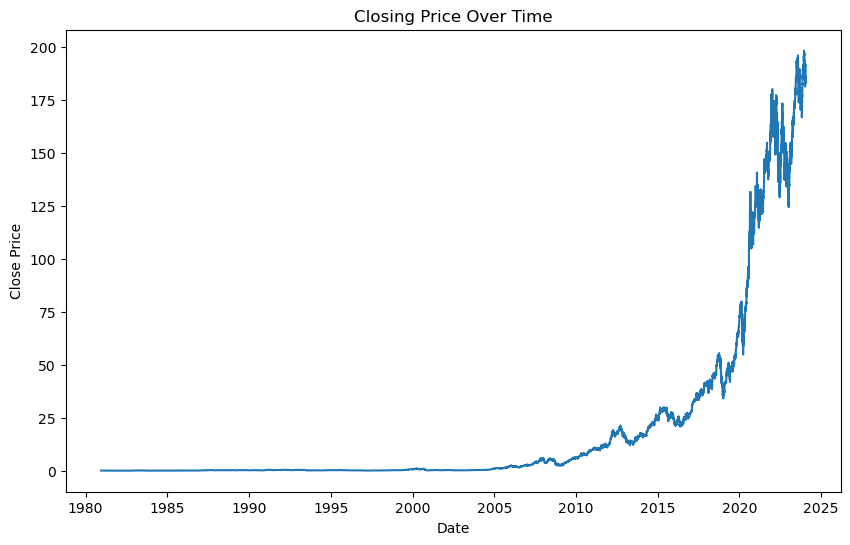

In [3]:
# Plot the closing prices to see the trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=data['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


### ALL data analysis

When you decompose a time series and evaluate the residuals, you're assessing how much of the data is not explained by the trend and seasonal components. Ideally, if the model perfectly captures the trend and seasonality of the time series, the residuals would be very close to zero, indicating no systematic patterns left unexplained.

In [4]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(data['Close'], model='additive', period=50)  # adjust the period based on data frequency

In [5]:
# Extract the residual component and use a unique name
additive_residuals = decomposition.resid.dropna()  # Drop NA to handle the edges

# Calculate error metrics assuming the ideal residuals would be zero
mae = np.mean(np.abs(additive_residuals))
mse = np.mean(additive_residuals ** 2)
rmse = np.sqrt(mse)

# Print the results
print("Mean Absolute Error ALL (MAE):", mae)
print("Mean Squared Error ALL(MSE):", mse)
print("Root Mean Squared Error ALL (RMSE):", rmse)



Mean Absolute Error ALL (MAE): 0.586955313132424
Mean Squared Error ALL(MSE): 2.594229463435785
Root Mean Squared Error ALL (RMSE): 1.6106611882813173


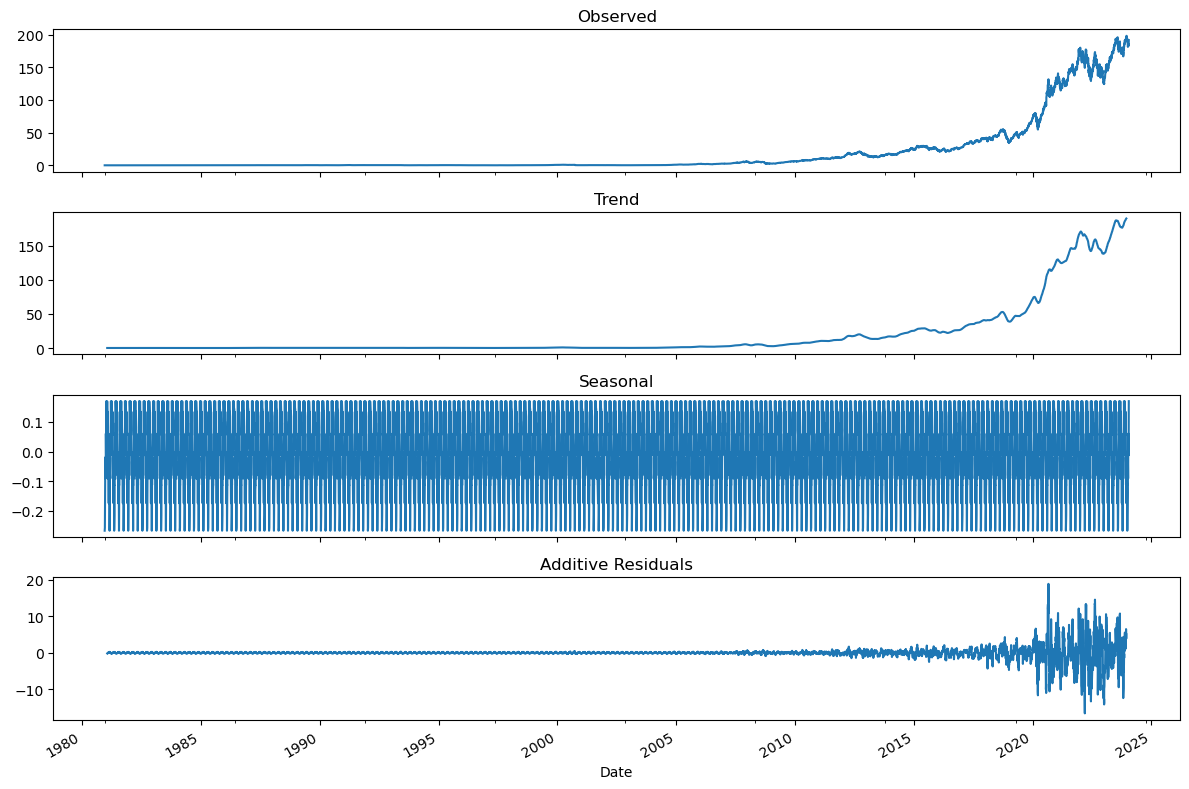

In [6]:
# Plot the components to visualize
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
additive_residuals.plot(ax=axes[3], title='Additive Residuals')
plt.tight_layout()
plt.show()

In [7]:
stl = STL(data['Close'], seasonal=51, period=50)  # 'seasonal' must be an odd integer
stl_result = stl.fit()

In [8]:
# Extract the residuals
residuals = stl_result.resid.dropna()  # Drop NA values which are typically at the start/end

# Calculate MSE, MAE, and RMSE
mse = np.mean(np.square(residuals))
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(mse)

# Print the results
print("Mean Squared Error ALL (MSE):", mse)
print("Mean Absolute Error ALL (MAE):", mae)
print("Root Mean Squared Error ALL (RMSE):", rmse)

Mean Squared Error ALL (MSE): 2.4005689765077074
Mean Absolute Error ALL (MAE): 0.5174570631464268
Root Mean Squared Error ALL (RMSE): 1.5493769639786528


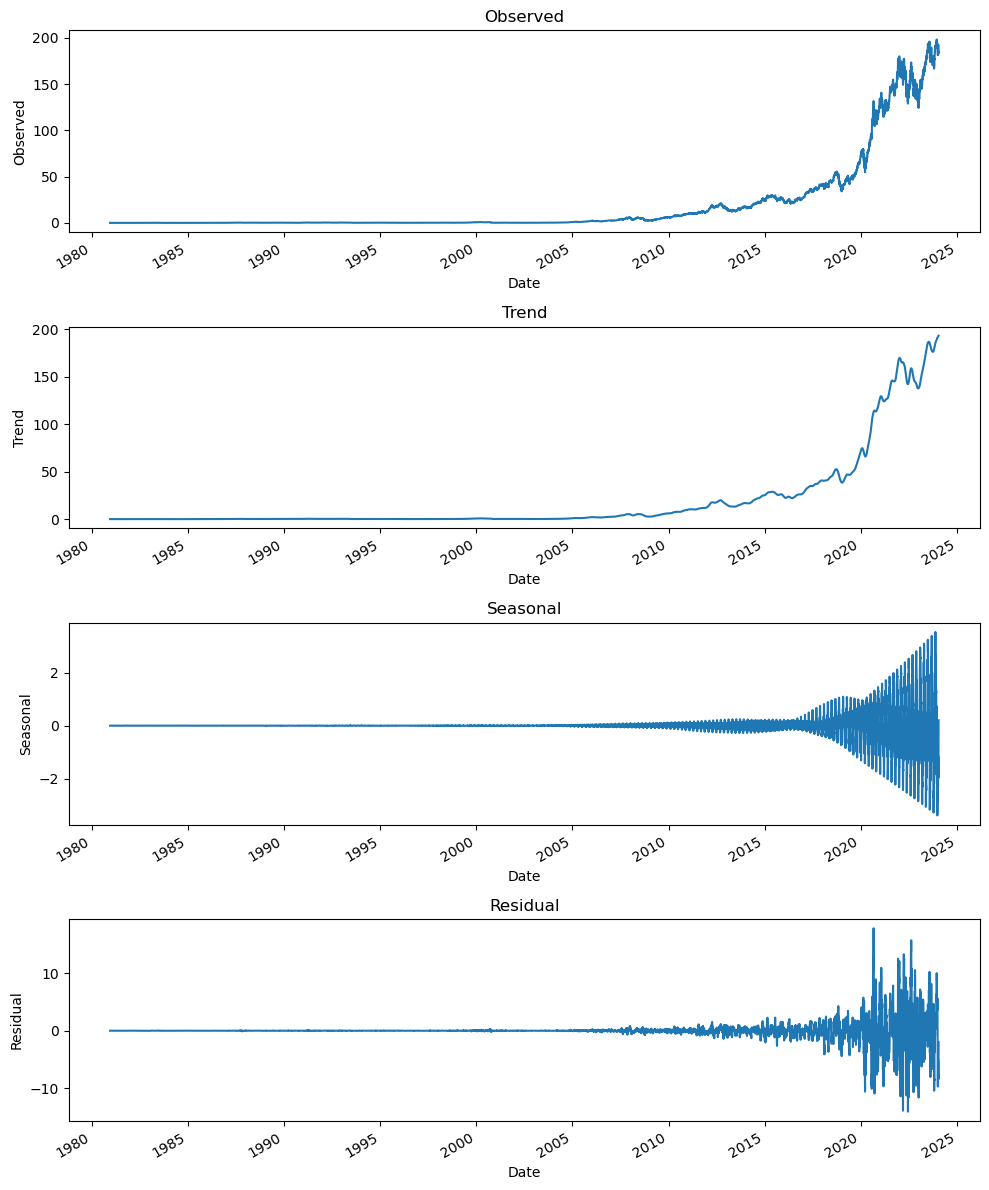

In [9]:
# Optionally, plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 12))
stl_result.observed.plot(ax=axes[0], title='Observed')
axes[0].set_ylabel('Observed')

stl_result.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Trend')

stl_result.seasonal.plot(ax=axes[2], title='Seasonal')
axes[2].set_ylabel('Seasonal')

stl_result.resid.plot(ax=axes[3], title='Residual')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### Post 2015 DATA

In [10]:
# Load your data
data_post2015 = pd.read_csv('./AAPL_full_history_stock_data.csv', index_col='Date', parse_dates=True)

# Convert index to datetime with UTC
data_post2015.index = pd.to_datetime(data_post2015.index, utc=True)

# Slice the data for post-2015
data_post_2015 = data_post2015['2015-01-01':]

# Calculate a 30-day rolling mean of the closing prices
rolling_mean = data_post_2015['Close'].rolling(window=30).mean()

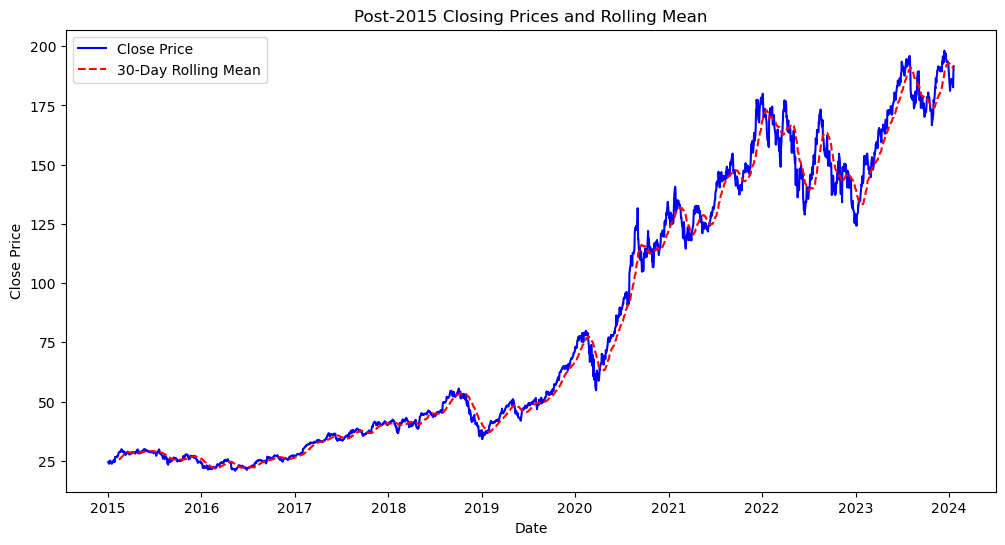

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data_post_2015['Close'], label='Close Price', color='blue')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='red', linestyle='--')
plt.title('Post-2015 Closing Prices and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [12]:
# Decompose the time series into trend, seasonal, and residual components
# Using an additive model with a period that might correspond to a business quarter or similar, adjust as needed
decomposition_post_2015 = seasonal_decompose(data_post_2015['Close'], model='additive', period=50)

additive_residuals_post2015 = decomposition_post_2015.resid.dropna()  # Drop NA to handle the edges

# Calculate error metrics assuming the ideal residuals would be zero
mae = np.mean(np.abs(additive_residuals_post2015))
mse = np.mean(additive_residuals_post2015 ** 2)
rmse = np.sqrt(mse)

# Print the results
print("Mean Absolute Error post 2015 (MAE):", mae)
print("Mean Squared Error post 2015(MSE):", mse)
print("Root Mean Squared Error post 2015 (RMSE):", rmse)



Mean Absolute Error post 2015 (MAE): 2.31220850993469
Mean Squared Error post 2015(MSE): 12.22463654993105
Root Mean Squared Error post 2015 (RMSE): 3.496374772522398


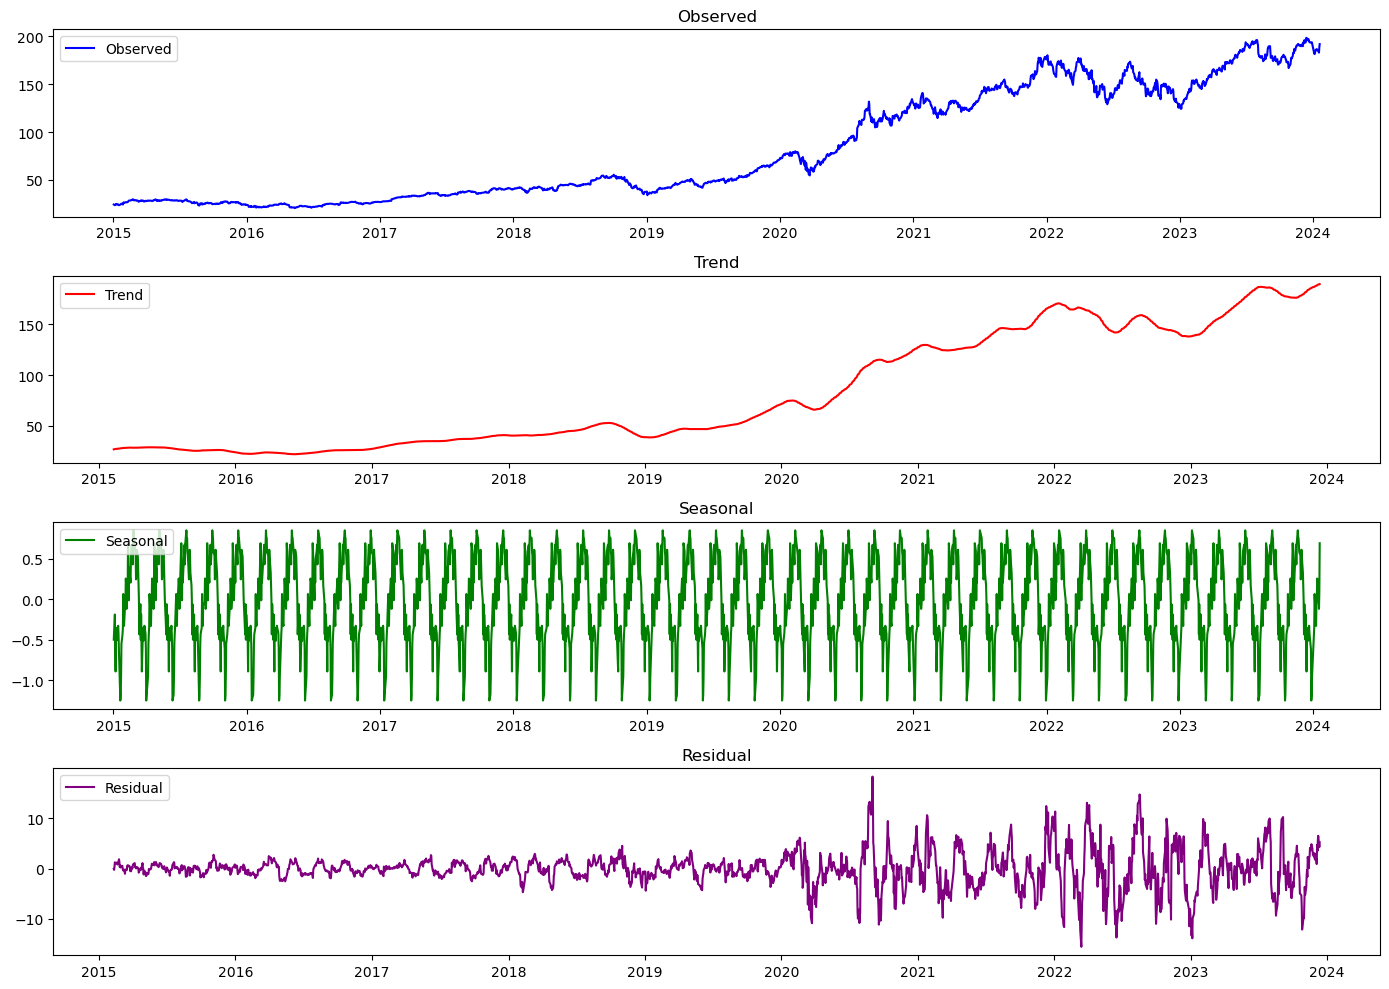

In [13]:
# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition_post_2015.observed, label='Observed', color='blue')
plt.legend(loc='upper left')
plt.title('Observed')

plt.subplot(412)
plt.plot(decomposition_post_2015.trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(413)
plt.plot(decomposition_post_2015.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

plt.subplot(414)
plt.plot(decomposition_post_2015.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()

In [14]:
# Apply the STL decomposition
# Adjust the 'period' based on your specific frequency and cycle knowledge
stl_POST2015 = STL(data_post_2015['Close'], seasonal=51, period=50)  # 'seasonal' must be an odd integer
stl_result_POST2015 = stl_POST2015.fit()

residuals_STL_POST2015 = stl_result_POST2015.resid.dropna()  # Drop NA values which are typically at the start/end

# Calculate MSE, MAE, and RMSE
mse = np.mean(np.square(residuals_STL_POST2015))
mae = np.mean(np.abs(residuals_STL_POST2015))
rmse = np.sqrt(mse)

# Print the results
print("Mean Squared Error POST2015 (MSE):", mse)
print("Mean Absolute Error POST2015 (MAE):", mae)
print("Root Mean Squared Error POST2015 (RMSE):", rmse)

Mean Squared Error POST2015 (MSE): 11.307838853734049
Mean Absolute Error POST2015 (MAE): 2.1823959237664443
Root Mean Squared Error POST2015 (RMSE): 3.362713019829978


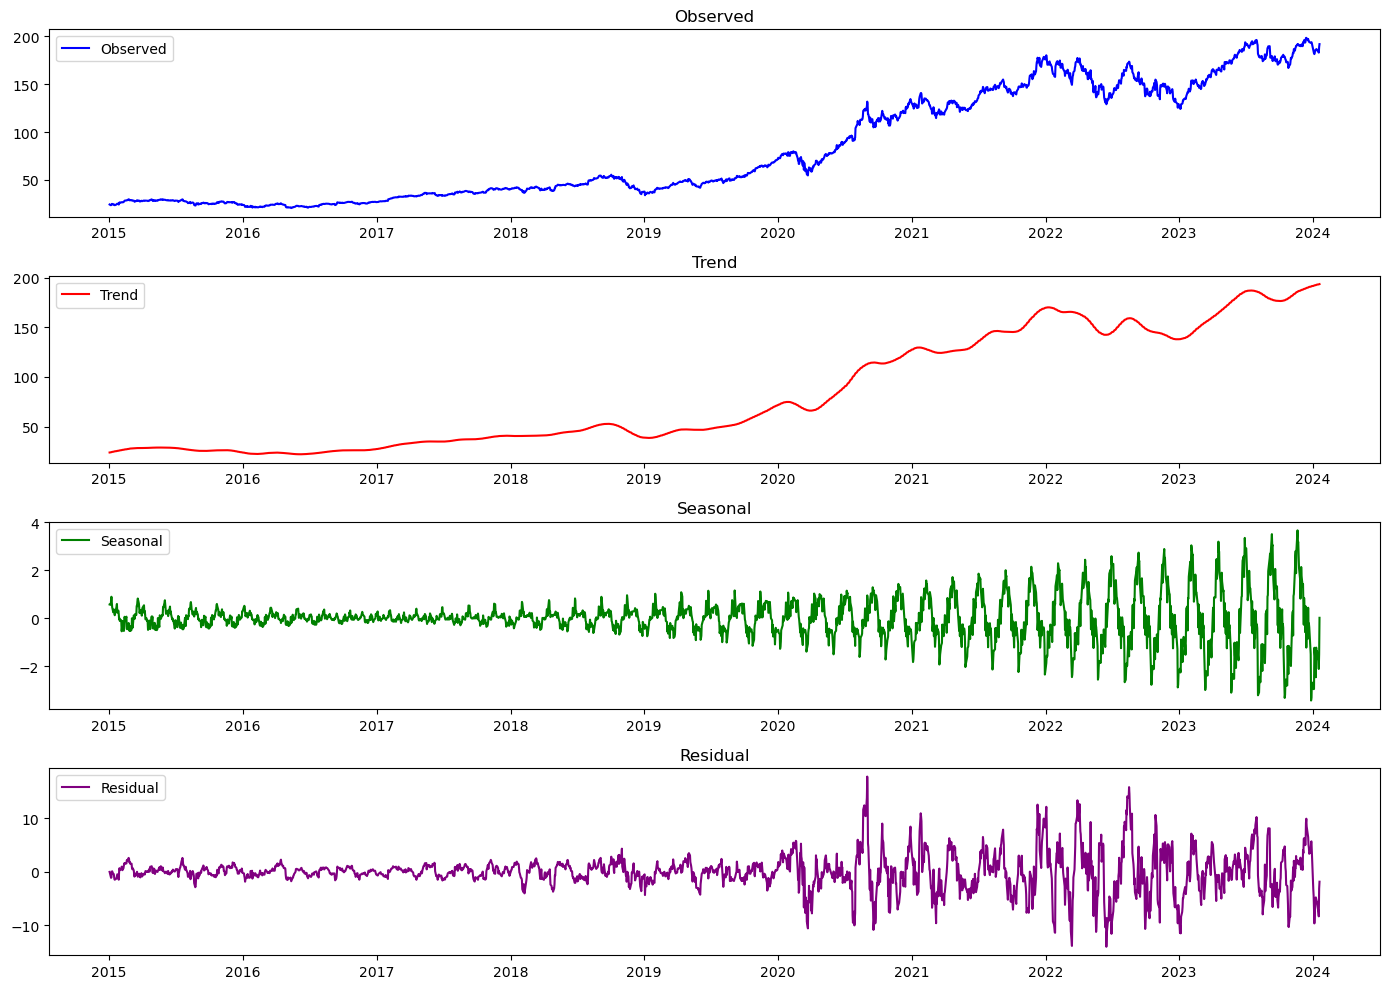

In [15]:
# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(stl_result_POST2015.observed, label='Observed', color='blue')
plt.legend(loc='upper left')
plt.title('Observed')

plt.subplot(412)
plt.plot(stl_result_POST2015.trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(413)
plt.plot(stl_result_POST2015.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

plt.subplot(414)
plt.plot(stl_result_POST2015.resid, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()

## TSLA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [2]:
TSLA=pd.read_csv("./stock_data_yf_new/TSLA.csv")
TSLA['Date'] = pd.to_datetime(TSLA['Date'])
TSLA.set_index('Date', inplace=True)

In [5]:
# Decompose the time series into trend, seasonal, and residual components

In [6]:
## Seasonal Decomposition of Time Series by Loess

In [4]:
decomposition = seasonal_decompose(TSLA['Close'], model='additive', period=50)  # adjust the period based on data frequency
additive_residuals = decomposition.resid.dropna()  # Drop NA to handle the edges

# Calculate error metrics assuming the ideal residuals would be zero
mae = np.mean(np.abs(additive_residuals))
mse = np.mean(additive_residuals ** 2)
rmse = np.sqrt(mse)

# Print the results
print("Mean Absolute Error ALL (MAE):", mae)
print("Mean Squared Error ALL(MSE):", mse)
print("Root Mean Squared Error ALL (RMSE):", rmse)


Mean Absolute Error ALL (MAE): 5.189617012017608
Mean Squared Error ALL(MSE): 95.624287642039
Root Mean Squared Error ALL (RMSE): 9.778767184161763


 Seasonal Decomposition of Time Series by Loess, often abbreviated as STL

In [7]:
stl = STL(TSLA['Close'], seasonal=51, period=50)  # 'seasonal' must be an odd integer
stl_result = stl.fit()
# Extract the residuals
residuals = stl_result.resid.dropna()  # Drop NA values which are typically at the start/end

# Calculate MSE, MAE, and RMSE
mse = np.mean(np.square(residuals))
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(mse)

# Print the results
print("Mean Squared Error ALL (MSE):", mse)
print("Mean Absolute Error ALL (MAE):", mae)
print("Root Mean Squared Error ALL (RMSE):", rmse)

Mean Squared Error ALL (MSE): 86.02761324018057
Mean Absolute Error ALL (MAE): 4.396539039993795
Root Mean Squared Error ALL (RMSE): 9.275107182139761


Flexibility and Robustness:

STL: Offers more flexibility and is generally more robust than classical decomposition methods. STL allows for setting different parameters for the seasonal component and can handle any type of seasonality, not just fixed seasonal effects. The use of Loess (or local regression) for both trend and seasonal components makes it adaptable to more complex and nuanced patterns in data.

Seasonal Decompose: Uses simpler moving averages to estimate trend and seasonal components, which can be less effective for complex patterns. It supports only basic additive or multiplicative models without the customization capabilities provided by Loess smoothing.



Handling Irregular Patterns:

STL: Can handle changing seasonal amplitudes and trends that do not repeat regularly over time due to its non-parametric nature (Loess smoothing). It's also better suited for handling outliers and missing data.

Seasonal Decompose: Best used when the seasonal pattern is regular and does not change over time, and when the data does not include outliers that could heavily influence the trend and seasonal estimates.

## Statistical model

### ARIMA Model Implementation for AAPL

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv("./AAPL_full_history_stock_data.csv", index_col='Date', parse_dates=True)
df.index = pd.to_datetime(df.index, utc=True)

# Check if the index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    print("Index is not a datetime type. Setting index as datetime...")
    df.index = pd.to_datetime(df.index)

# Ensure a continuous index with a uniform frequency
print("Index frequency:", df.index.inferred_freq)
if df.index.inferred_freq is None:
    print("Index does not have a recognized frequency. Attempting to set a regular frequency...")
    df = df.asfreq('B')  # 'B' stands for business day frequency
    df = df.fillna(method='ffill')  # Forward fill to handle missing values if any

print("New index frequency:", df.index.inferred_freq)

Index frequency: None
Index does not have a recognized frequency. Attempting to set a regular frequency...
New index frequency: B


In [3]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(inplace=True)
# Print the total number of rows after cleaning
print("Total number of rows in the dataset after cleaning:", df.shape[0])

Total number of rows in the dataset after cleaning: 11246


In [4]:
# Calculate the split index
split_index = int(len(df) * 0.8)  # 80% for training

# Split data into train and test sets
train = df['Close'].iloc[:split_index]
test = df['Close'].iloc[split_index:]

# Print the total number of rows in the dataset after cleaning
print("Total number of rows in the dataset after cleaning:", df.shape[0])

# Print details about the train and test sets
print("Number of rows in the train set:", train.shape[0])
print("Number of rows in the test set:", test.shape[0])

Total number of rows in the dataset after cleaning: 11246
Number of rows in the train set: 8996
Number of rows in the test set: 2250


In [5]:
# Check for NaNs in the training dataset
if train.isna().any():
    print("NaN values detected in training data.")
else:
    print("No NaN values in training data.")


No NaN values in training data.


In [6]:
def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    return result

adf_result = perform_adf_test(train)
d_value = 0 if adf_result[1] < 0.05 else 1


ADF Statistic: 3.5213937480610222
p-value: 1.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [7]:
model_arima = auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3, m=1, d=d_value, seasonal=False, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True, maxiter=50)
fc, confint = model_arima.predict(n_periods=len(test), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11731.261, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11729.263, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11729.261, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11727.639, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11727.261, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.402 seconds


In [8]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)

In [9]:
# Calculate errors
mse = np.mean((test.values - fc_series.values) ** 2)
mae = np.mean(np.abs(test.values - fc_series.values))
rmse = np.sqrt(mse)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')

Mean Squared Error (MSE): 4882.974
Mean Absolute Error (MAE): 48.945
Root Mean Squared Error (RMSE): 69.878


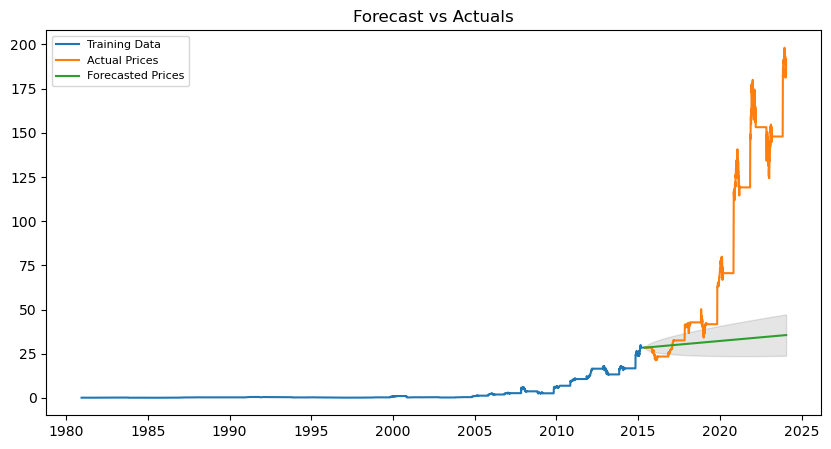

In [10]:
# Plot the forecast against the actual outcomes
plt.figure(figsize=(10, 5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Prices')
plt.plot(fc_series, label='Forecasted Prices')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### ETS Model Implementation for AAPL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load data
df = pd.read_csv("./AAPL_full_history_stock_data.csv", index_col='Date', parse_dates=True)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert 'Close' to numeric, handle non-numeric gracefully
df.dropna(inplace=True)  # Drop any rows with NaN values which might be introduced by invalid parsing


In [3]:
# Calculate the split index
split_index = int(len(df) * 0.8)  # 80% for training

# Split data into train and test sets
train = df['Close'].iloc[:split_index]
test = df['Close'].iloc[split_index:]

# Print the total number of rows in the dataset after cleaning
print("Total number of rows in the dataset after cleaning:", df.shape[0])

# Print details about the train and test sets
print("Number of rows in the train set:", train.shape[0])
print("Number of rows in the test set:", test.shape[0])

Total number of rows in the dataset after cleaning: 10866
Number of rows in the train set: 8692
Number of rows in the test set: 2174


In [4]:
# Fit an ETS Model
# Assuming that the data does not have a strong seasonal component
model_ets = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=True, seasonal_periods=None).fit()

# Forecast for the length of the test set
ets_forecast = model_ets.forecast(len(test))

/Users/songyuren/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/songyuren/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/songyuren/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [5]:
# Calculate error metrics
mse = mean_squared_error(test, ets_forecast)
mae = mean_absolute_error(test, ets_forecast)
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Mean Squared Error (MSE): 6010.276
Mean Absolute Error (MAE): 55.379
Root Mean Squared Error (RMSE): 77.526


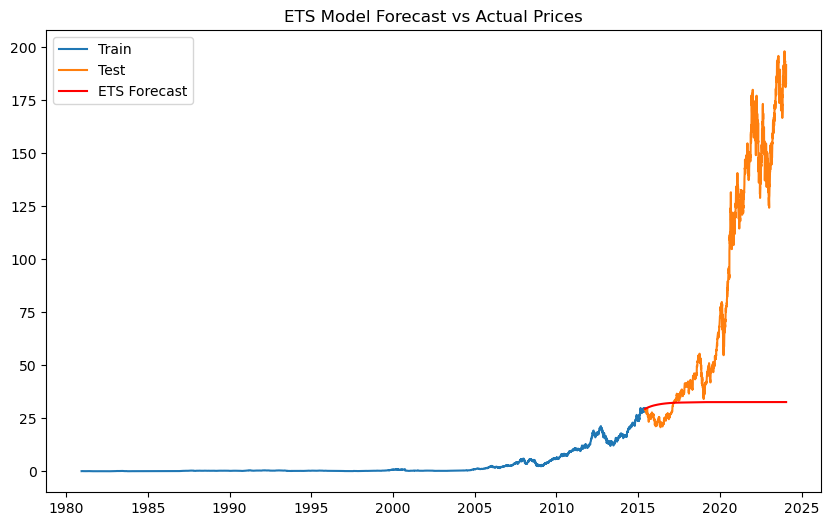

In [6]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, ets_forecast, color='red', label='ETS Forecast')
plt.title('ETS Model Forecast vs Actual Prices')
plt.legend()
plt.show()

In [7]:
# Load your data
data_post2015 = pd.read_csv('./AAPL_full_history_stock_data.csv', index_col='Date', parse_dates=True)

# Convert index to datetime with UTC
data_post2015.index = pd.to_datetime(data_post2015.index, utc=True)

# Slice the data for post-2015
data_post_2015 = data_post2015['2015-01-01':]

In [8]:
data_post_2015.dropna(inplace=True)

/var/folders/vc/rsz0psl95p91gtznnnjzrxb80000gn/T/ipykernel_6861/1979321112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_post_2015.dropna(inplace=True)


In [9]:
# Calculate the split index for an 80/20 train/test split
split_index = int(len(data_post_2015) * 0.8)  # 80% for training

# Split data into train and test sets
train = data_post_2015['Close'].iloc[:split_index]
test = data_post_2015['Close'].iloc[split_index:]

# Print the total number of rows in the dataset after cleaning
print("Total number of rows in the dataset after cleaning:", data_post_2015.shape[0])
print("Number of rows in the train set:", train.shape[0])
print("Number of rows in the test set:", test.shape[0])

# Fit an ETS Model assuming no strong seasonal component
model_ets = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=True, seasonal_periods=None).fit()

# Forecast the next number of periods equivalent to the size of the test set
ets_forecast = model_ets.forecast(len(test))

# Calculate the MSE, MAE, and RMSE
mse = mean_squared_error(test, ets_forecast)
mae = mean_absolute_error(test, ets_forecast)
rmse = np.sqrt(mse)

# Print the metrics
print(f'ETS Model MSE: {mse:.2f}')
print(f'ETS Model RMSE: {rmse:.2f}')
print(f'ETS Model MAE: {mae:.2f}')

Total number of rows in the dataset after cleaning: 2277
Number of rows in the train set: 1821
Number of rows in the test set: 456
ETS Model MSE: 614.10
ETS Model RMSE: 24.78
ETS Model MAE: 20.15


/Users/songyuren/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/songyuren/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/songyuren/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### ARIMA model for TSLA 

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv("./stock_data_yf_new/TSLA.csv", index_col='Date', parse_dates=True)
df.index = pd.to_datetime(df.index, utc=True)

# Check if the index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    print("Index is not a datetime type. Setting index as datetime...")
    df.index = pd.to_datetime(df.index)

# Ensure a continuous index with a uniform frequency
print("Index frequency:", df.index.inferred_freq)
if df.index.inferred_freq is None:
    print("Index does not have a recognized frequency. Attempting to set a regular frequency...")
    df = df.asfreq('B')  # 'B' stands for business day frequency
    df = df.fillna(method='ffill')  # Forward fill to handle missing values if any

print("New index frequency:", df.index.inferred_freq)

Index frequency: None
Index does not have a recognized frequency. Attempting to set a regular frequency...
New index frequency: B


/var/folders/vc/rsz0psl95p91gtznnnjzrxb80000gn/T/ipykernel_54560/1323621462.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill to handle missing values if any


In [3]:
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(inplace=True)
# Print the total number of rows after cleaning
print("Total number of rows in the dataset after cleaning:", df.shape[0])

Total number of rows in the dataset after cleaning: 3539


In [4]:
# Calculate the split index
split_index = int(len(df) * 0.8)  # 80% for training

# Split data into train and test sets
train = df['Close'].iloc[:split_index]
test = df['Close'].iloc[split_index:]

# Print the total number of rows in the dataset after cleaning
print("Total number of rows in the dataset after cleaning:", df.shape[0])

# Print details about the train and test sets
print("Number of rows in the train set:", train.shape[0])
print("Number of rows in the test set:", test.shape[0])

Total number of rows in the dataset after cleaning: 3539
Number of rows in the train set: 2831
Number of rows in the test set: 708


In [5]:
# Check for NaNs in the training dataset
if train.isna().any():
    print("NaN values detected in training data.")
else:
    print("No NaN values in training data.")


No NaN values in training data.


In [6]:
def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    return result

adf_result = perform_adf_test(train)
d_value = 0 if adf_result[1] < 0.05 else 1


ADF Statistic: 2.937424893217623
p-value: 1.0
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [7]:
model_arima = auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3, m=1, d=d_value, seasonal=False, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True, maxiter=50)
fc, confint = model_arima.predict(n_periods=len(test), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13395.663, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13371.749, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13372.522, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13396.304, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13373.208, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13372.772, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13374.393, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13372.954, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.021 seconds


In [8]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)

In [9]:
# Calculate errors
mse = np.mean((test.values - fc_series.values) ** 2)
mae = np.mean(np.abs(test.values - fc_series.values))
rmse = np.sqrt(mse)

# Print the error metrics
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')

Mean Squared Error (MSE): 5958.269
Mean Absolute Error (MAE): 58.044
Root Mean Squared Error (RMSE): 77.190


### ETS model TSLA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load data
df = pd.read_csv("./stock_data_yf_new/TSLA.csv", index_col='Date', parse_dates=True)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert 'Close' to numeric, handle non-numeric gracefully
df.dropna(inplace=True)  # Drop any rows with NaN values which might be introduced by invalid parsing


In [3]:
# Calculate the split index
split_index = int(len(df) * 0.8)  # 80% for training

# Split data into train and test sets
train = df['Close'].iloc[:split_index]
test = df['Close'].iloc[split_index:]

# Print the total number of rows in the dataset after cleaning
print("Total number of rows in the dataset after cleaning:", df.shape[0])

# Print details about the train and test sets
print("Number of rows in the train set:", train.shape[0])
print("Number of rows in the test set:", test.shape[0])

Total number of rows in the dataset after cleaning: 3413
Number of rows in the train set: 2730
Number of rows in the test set: 683


In [4]:
# Fit an ETS Model
# Assuming that the data does not have a strong seasonal component
model_ets = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=True, seasonal_periods=None).fit()

# Forecast for the length of the test set
ets_forecast = model_ets.forecast(len(test))

/Users/songyuren/anaconda3/envs/GNN/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/songyuren/anaconda3/envs/GNN/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/songyuren/anaconda3/envs/GNN/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [5]:
# Calculate error metrics
mse = mean_squared_error(test, ets_forecast)
mae = mean_absolute_error(test, ets_forecast)
rmse = np.sqrt(mse)

# Print the error metrics
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Mean Squared Error (MSE): 3708.006
Mean Absolute Error (MAE): 46.596
Root Mean Squared Error (RMSE): 60.893


## N-BEATS

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Load and prepare data
data = pd.read_csv('./AAPL_full_history_stock_data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)

# Selecting the 'Close' price for prediction
data = data[['Close']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0]  # Flatten the sequence into 1D
        y = data[i+seq_length, 0]  # Target value is a scalar
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 20  # Length of the input sequence
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X[:int(len(X)*0.8)], dtype=torch.float32), torch.tensor(y[:int(len(y)*0.8)], dtype=torch.float32)
X_test, y_test = torch.tensor(X[int(len(X)*0.8):], dtype=torch.float32), torch.tensor(y[int(len(y)*0.8):], dtype=torch.float32)

# DataLoader for training
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)


In [2]:
def absolute_errors(y_pred, y_true):
    """Calculate the absolute differences between predictions and true values."""
    return torch.abs(y_pred - y_true)


In [3]:
import torch.nn as nn


# Check if MPS is available and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

class NBeatsNet(nn.Module):
    def __init__(self, seq_length):
        super(NBeatsNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        output = self.stack(x)
        return output.view(-1)  # Reshape output to match target shape [batch_size]


# Initialize model
model = NBeatsNet(seq_length).to(device)



Using device: mps


In [4]:
def train_model(model, train_loader, test_loader, num_epochs=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch)
                loss = criterion(output, y_batch)
                test_loss += loss.item()
        print(f'Epoch {epoch+1}, Test Loss: {test_loss / len(test_loader)}')

# Train the model
train_model(model, train_loader, test_loader)


/Users/songyuren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 1, Test Loss: 0.028715939110389603
Epoch 2, Test Loss: 0.030012961002101105
Epoch 3, Test Loss: 0.032377784242998704
Epoch 4, Test Loss: 0.04000002451752368
Epoch 5, Test Loss: 0.04540349312815759


### N-beats with conformal prediciton AAPL

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load and prepare data
data = pd.read_csv('./AAPL_full_history_stock_data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)  # Convert to UTC datetime

In [3]:
# Selecting the 'Close' price for prediction
data = data[['Close']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [4]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length), 0]  # Flatten the sequence into 1D
        y = data[i + seq_length, 0]  # Target value is a scalar
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
seq_length = 50  # Length of the input sequence
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X[:int(len(X)*0.8)], dtype=torch.float32), torch.tensor(y[:int(len(y)*0.8)], dtype=torch.float32)
X_test, y_test = torch.tensor(X[int(len(X)*0.8):], dtype=torch.float32), torch.tensor(y[int(len(y)*0.8):], dtype=torch.float32)


In [6]:
# DataLoader for training
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)


In [7]:
# Check if MPS is available and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [8]:
class NBeatsNet(nn.Module):
    def __init__(self, seq_length):
        super(NBeatsNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.stack(x).view(-1)  # Reshape output to match target shape [batch_size]



In [9]:
def train_model(model, train_loader, test_loader, num_epochs=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()  # Training mode
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1} completed.')

    # Move to evaluation phase after all epochs
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            predictions.extend(output.view(-1).cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    # Calculate and print overall MSE, MAE, RMSE
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)  # sqrt of MSE

    print(f"Overall Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


In [10]:
# Initialize model
model = NBeatsNet(seq_length).to(device)

In [11]:
# Train the model, assuming train_loader and test_loader are defined
train_model(model, train_loader, test_loader)

/Users/songyuren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Overall Test MSE: 0.0014, MAE: 0.0263, RMSE: 0.0380


In [12]:
def conformal_prediction(model, train_loader, test_loader, alpha=0.05, device='mps'):
    # Set model to evaluation mode
    model.eval()
    
    # Collect all scores from training
    all_train_scores = []
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            scores = torch.abs(y_pred - y_batch)  # Assuming absolute_errors is this
            all_train_scores.extend(scores.cpu().numpy())

    # Determine the threshold for prediction intervals
    quantile = np.quantile(all_train_scores, 1 - alpha)

    # Apply conformal prediction on the test set
    predictions = []
    intervals = []
    test_values = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            lower_bounds = y_pred - quantile
            upper_bounds = y_pred + quantile
            predictions.extend(y_pred.cpu().numpy())
            intervals.extend(list(zip(lower_bounds.cpu().numpy(), upper_bounds.cpu().numpy())))
            test_values.extend(y_batch.cpu().numpy())

    return predictions, intervals, test_values


In [13]:
# Alpha values to test
alpha_values = [0.05, 0.04, 0.03, 0.02, 0.01]

# Dictionary to store results
coverage_results = {}

In [14]:
for alpha in alpha_values:
    # Run conformal prediction
    predictions, intervals, test_values = conformal_prediction(model, train_loader, test_loader, alpha, device)

    # Inverse transform on predictions and intervals
    original_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    original_intervals = [
        (scaler.inverse_transform(np.array([lb]).reshape(-1, 1))[0,0], 
         scaler.inverse_transform(np.array([ub]).reshape(-1, 1))[0,0]) 
        for lb, ub in intervals
    ]
    original_test_values = scaler.inverse_transform(np.array(test_values).reshape(-1, 1)).flatten()

    # Check if actual test data falls within the intervals
    containment_check = [lower <= actual <= upper for (lower, upper), actual in zip(original_intervals, original_test_values)]

    # Calculate the percentage of test values contained within the intervals
    coverage_percentage = sum(containment_check) / len(containment_check) * 100

    # Store results
    coverage_results[alpha] = coverage_percentage
    print(f"Coverage for alpha={alpha}: {coverage_percentage:.2f}%")

Coverage for alpha=0.05: 19.69%
Coverage for alpha=0.04: 21.08%
Coverage for alpha=0.03: 24.60%
Coverage for alpha=0.02: 28.02%
Coverage for alpha=0.01: 32.82%


In [15]:
# Print all results
for alpha, coverage in coverage_results.items():
    print(f"Alpha {alpha}: Coverage {coverage:.2f}%")

Alpha 0.05: Coverage 19.69%
Alpha 0.04: Coverage 21.08%
Alpha 0.03: Coverage 24.60%
Alpha 0.02: Coverage 28.02%
Alpha 0.01: Coverage 32.82%


### With Shap explainaiton and conformal prediction (AAPL)

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import shap  # Import SHAP library

In [2]:
# Load and prepare data
data = pd.read_csv('./AAPL_full_history_stock_data.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)  # Convert to UTC datetime

In [3]:
# Selecting the 'Close' price for prediction
data = data[['Close']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [4]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length), 0]  # Flatten the sequence into 1D
        y = data[i + seq_length, 0]  # Target value is a scalar
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
seq_length = 20  # Length of the input sequence
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X[:int(len(X)*0.8)], dtype=torch.float32), torch.tensor(y[:int(len(y)*0.8)], dtype=torch.float32)
X_test, y_test = torch.tensor(X[int(len(X)*0.8):], dtype=torch.float32), torch.tensor(y[int(len(y)*0.8):], dtype=torch.float32)

In [6]:
# DataLoader for training
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

In [7]:
# Check if MPS is available and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [8]:
class NBeatsNet(nn.Module):
    def __init__(self, seq_length):
        super(NBeatsNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        output = self.stack(x)
        return output.view(-1, 1)  # Ensure output is 2D [batch_size, 1]


In [9]:
model = NBeatsNet(seq_length).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


/Users/songyuren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [10]:
# Train the model
def train_model(model, train_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1} completed.')

In [11]:
# Train the model
train_model(model, train_loader)

/Users/songyuren/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/songyuren/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.


In [12]:
# Implement conformal prediction
def absolute_errors(y_pred, y_true):
    return torch.abs(y_pred - y_true)


In [13]:
def conformal_prediction(model, train_loader, test_loader, alpha=0.05):
    model.eval()
    all_train_scores = []
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch).view(-1)  # Ensure y_pred is flattened
            scores = absolute_errors(y_pred, y_batch)
            all_train_scores.extend(scores.cpu().numpy())  # Convert to numpy here, ensure it's flat

    quantile = np.quantile(all_train_scores, 1 - alpha)  # Should now work as expected

    predictions = []
    intervals = []
    with torch.no_grad():
        for x_batch in test_loader.dataset.tensors[0].to(device):
            y_pred = model(x_batch.unsqueeze(0)).flatten()  # Ensure this is flattened as well
            lower_bounds = y_pred - quantile
            upper_bounds = y_pred + quantile
            predictions.extend(y_pred.cpu().numpy())  # Ensure we're only extending with flat data
            intervals.append((lower_bounds.item(), upper_bounds.item()))  # Make sure these are scalars

    return predictions, intervals


In [14]:
predictions, intervals = conformal_prediction(model, train_loader, test_loader)
# print(predictions)
# print(intervals)

In [15]:
# Initialize the SHAP explainer
background = X_train[:100].to(device)  # Use a background dataset
explainer = shap.GradientExplainer((model, model.stack[0]), background)  # Initialize correctly

# Check shapes and content
print("SHAP values shape:", np.array(shap_values).shape)
print("SHAP values example:", shap_values[0])

NameError: name 'shap_values' is not defined

In [21]:
# Select a sample from the test set
X_test_sample = X_test[:10].to(device)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Compute expected value (average model output over background)
expected_value = model(background).mean().item()

# Print shapes for debugging
print("Shape of SHAP values:", np.array(shap_values[0]).shape)  # should be (10, 20) or similar
print("Shape of features:", X_test_sample[0].cpu().numpy().shape)  # should be (20,)


DimensionError: Length of features is not equal to the length of shap_values!

# TSLA in LSTM and N-Beats 

### LSTM with full data with conformal prediction (TSLA)

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

In [2]:
# Load data
data = pd.read_csv('./stock_data_yf_new/TSLA.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)  # Convert to UTC datetime

# Apply scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Close']].values)
# Convert numpy array back to DataFrame
df_scaled = pd.DataFrame(data_scaled, index=data.index, columns=['Scaled_Close'])
# Filter data
# df_filtered = df_scaled[df_scaled.index > pd.Timestamp('2008-01-01', tz='UTC')]

In [3]:
# Create sequences
def create_sequences(data, sequence_length=50):
    xs, ys = [], []
    data = data.values.flatten()  # Ensure data is a flattened numpy array
    for i in range(len(data) - sequence_length):
        xs.append(data[i:(i + sequence_length)])
        ys.append(data[i + sequence_length])
    return np.array(xs), np.array(ys)

X, y = create_sequences(df_scaled)


In [4]:
# Convert to tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add a channel dimension
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Ensure y is [batch_size, 1]

# Split data
split_point = int(0.8 * len(X))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [5]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

In [7]:
# Initialize model, loss, and optimizer
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=1, hidden_size=10, num_layers=2, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Users/songyuren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [8]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    test_losses = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            test_loss = criterion(outputs, y_batch)
            test_losses.append(test_loss.item())

    avg_test_loss = np.mean(test_losses)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

Epoch 1/5, Train Loss: 0.0150, Test Loss: 0.1966
Epoch 2/5, Train Loss: 0.0243, Test Loss: 0.2610
Epoch 3/5, Train Loss: 0.0204, Test Loss: 0.2625
Epoch 4/5, Train Loss: 0.0197, Test Loss: 0.2577
Epoch 5/5, Train Loss: 0.0188, Test Loss: 0.2424


In [9]:
# After training, evaluate on test data
all_preds, all_y = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        all_preds.extend(outputs.cpu().numpy())
        all_y.extend(y_batch.cpu().numpy())

# Convert lists to numpy arrays for easier manipulation
all_preds = np.array(all_preds)
all_y = np.array(all_y)

# Calculate MAE and RMSE using numpy
mse = np.mean((all_preds - all_y) ** 2)
mae = np.mean(np.abs(all_preds - all_y))
rmse = np.sqrt(mse)

# Output the results
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test RMSE: {rmse:.4f}')

Test MSE: 0.2463
Test MAE: 0.4782
Test RMSE: 0.4963


In [10]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
def conformal_prediction(model, train_loader, test_loader, device, scaler, alpha):
    model.eval()
    all_train_scores = []
    # Calculate the absolute differences for the training set to find the quantile
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            scores = torch.abs(y_pred - y_batch).cpu().numpy()
            all_train_scores.extend(scores)

    # Compute the quantile for the confidence level
    quantile = np.quantile(all_train_scores, 1 - alpha)
    predictions, intervals = [], []
    
    # Generate predictions and intervals for the test set
    with torch.no_grad():
        for x_batch, _ in test_loader:
            x_batch = x_batch.to(device)
            y_pred = model(x_batch)
            lower_bounds = y_pred - quantile
            upper_bounds = y_pred + quantile
            predictions.extend(y_pred.cpu().numpy())
            intervals.extend(list(zip(lower_bounds.cpu().numpy(), upper_bounds.cpu().numpy())))

    # Convert predictions and intervals back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    intervals = [(scaler.inverse_transform(np.array([low]).reshape(-1, 1))[0][0],
                  scaler.inverse_transform(np.array([high]).reshape(-1, 1))[0][0]) for low, high in intervals]
    
    return predictions, intervals


In [12]:
# Using different alpha values
alpha_values = [0.05, 0.04, 0.03, 0.02, 0.01]
for alpha in alpha_values:
    predictions, intervals = conformal_prediction(model, train_loader, test_loader, device, scaler, alpha)
    y_test_scaled_back = scaler.inverse_transform(y_test.cpu().numpy())
    in_interval = [lower <= actual <= upper for actual, (lower, upper) in zip(y_test_scaled_back.flatten(), intervals)]
    percentage_in_interval = 100 * sum(in_interval) / len(in_interval)
    print(f"Alpha {alpha:.2f}: Percentage of actual values within prediction intervals: {percentage_in_interval:.2f}%")

Alpha 0.05: Percentage of actual values within prediction intervals: 3.57%
Alpha 0.04: Percentage of actual values within prediction intervals: 19.17%
Alpha 0.03: Percentage of actual values within prediction intervals: 33.28%
Alpha 0.02: Percentage of actual values within prediction intervals: 39.82%
Alpha 0.01: Percentage of actual values within prediction intervals: 66.72%


## N-beats with full data with conformal prediction (TSLA)

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load and prepare data
data = pd.read_csv('./stock_data_yf_new/TSLA.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index, utc=True)  # Convert to UTC datetime

In [3]:
# Selecting the 'Close' price for prediction
data = data[['Close']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [4]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length), 0]  # Flatten the sequence into 1D
        y = data[i + seq_length, 0]  # Target value is a scalar
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [5]:
seq_length = 50  # Length of the input sequence
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X[:int(len(X)*0.8)], dtype=torch.float32), torch.tensor(y[:int(len(y)*0.8)], dtype=torch.float32)
X_test, y_test = torch.tensor(X[int(len(X)*0.8):], dtype=torch.float32), torch.tensor(y[int(len(y)*0.8):], dtype=torch.float32)

In [6]:
# DataLoader for training
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)

In [7]:
# Check if MPS is available and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [8]:
class NBeatsNet(nn.Module):
    def __init__(self, seq_length):
        super(NBeatsNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.stack(x).view(-1)  # Reshape output to match target shape [batch_size]

In [9]:
def train_model(model, train_loader, test_loader, num_epochs=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()  # Training mode
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1} completed.')

    # Move to evaluation phase after all epochs
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            predictions.extend(output.view(-1).cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    # Calculate and print overall MSE, MAE, RMSE
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)  # sqrt of MSE

    print(f"Overall Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

In [10]:
# Initialize model
model = NBeatsNet(seq_length).to(device)

In [11]:
# Train the model, assuming train_loader and test_loader are defined
train_model(model, train_loader, test_loader)

/Users/songyuren/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Overall Test MSE: 0.0046, MAE: 0.0559, RMSE: 0.0682


In [12]:
def conformal_prediction(model, train_loader, test_loader, alpha=0.05, device='mps'):
    # Set model to evaluation mode
    model.eval()
    
    # Collect all scores from training
    all_train_scores = []
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            scores = torch.abs(y_pred - y_batch)  # Assuming absolute_errors is this
            all_train_scores.extend(scores.cpu().numpy())

    # Determine the threshold for prediction intervals
    quantile = np.quantile(all_train_scores, 1 - alpha)

    # Apply conformal prediction on the test set
    predictions = []
    intervals = []
    test_values = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            lower_bounds = y_pred - quantile
            upper_bounds = y_pred + quantile
            predictions.extend(y_pred.cpu().numpy())
            intervals.extend(list(zip(lower_bounds.cpu().numpy(), upper_bounds.cpu().numpy())))
            test_values.extend(y_batch.cpu().numpy())

    return predictions, intervals, test_values

In [13]:
# Alpha values to test
alpha_values = [0.05, 0.04, 0.03, 0.02, 0.01]

# Dictionary to store results
coverage_results = {}

In [14]:
for alpha in alpha_values:
    # Run conformal prediction
    predictions, intervals, test_values = conformal_prediction(model, train_loader, test_loader, alpha, device)

    # Inverse transform on predictions and intervals
    original_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    original_intervals = [
        (scaler.inverse_transform(np.array([lb]).reshape(-1, 1))[0,0], 
         scaler.inverse_transform(np.array([ub]).reshape(-1, 1))[0,0]) 
        for lb, ub in intervals
    ]
    original_test_values = scaler.inverse_transform(np.array(test_values).reshape(-1, 1)).flatten()

    # Check if actual test data falls within the intervals
    containment_check = [lower <= actual <= upper for (lower, upper), actual in zip(original_intervals, original_test_values)]

    # Calculate the percentage of test values contained within the intervals
    coverage_percentage = sum(containment_check) / len(containment_check) * 100

    # Store results
    coverage_results[alpha] = coverage_percentage
    print(f"Coverage for alpha={alpha}: {coverage_percentage:.2f}%")

Coverage for alpha=0.05: 20.65%
Coverage for alpha=0.04: 28.08%
Coverage for alpha=0.03: 37.44%
Coverage for alpha=0.02: 48.44%
Coverage for alpha=0.01: 69.54%


In [15]:
# Print all results
for alpha, coverage in coverage_results.items():
    print(f"Alpha {alpha}: Coverage {coverage:.2f}%")

Alpha 0.05: Coverage 20.65%
Alpha 0.04: Coverage 28.08%
Alpha 0.03: Coverage 37.44%
Alpha 0.02: Coverage 48.44%
Alpha 0.01: Coverage 69.54%


# GNN

## AAPL

In [1]:
import pandas as pd
import numpy as np
import ta
import torch
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data from the CSV file
data = pd.read_csv('AAPL_full_history_stock_data.csv', parse_dates=['Date'])

# Set the 'Date' column as the index of the DataFrame
data.set_index('Date', inplace=True)

# Print out the column names
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [3]:
# Get unique values from the 'Dividends' column
dividends_unique = data['Dividends'].unique()
print("Unique values in 'Dividends':", dividends_unique)

# Get unique values from the 'Stock Splits' column
stock_splits_unique = data['Stock Splits'].unique()
print("Unique values in 'Stock Splits':", stock_splits_unique)

Unique values in 'Dividends': [0.       0.000536 0.000714 0.000893 0.000982 0.001071 0.094643 0.108929
 0.1175   0.13     0.1425   0.1575   0.1825   0.1925   0.205    0.22
 0.23     0.24    ]
Unique values in 'Stock Splits': [0. 2. 7. 4.]


In [4]:
# Calculate Moving Averages
data['SMA_50'] = ta.trend.sma_indicator(data['Close'], window=50)  # 50-day Simple Moving Average
data['SMA_200'] = ta.trend.sma_indicator(data['Close'], window=200)  # 200-day Simple Moving Average

# Calculate RSI
data['RSI_14'] = ta.momentum.rsi(data['Close'], window=14)  # 14-day Relative Strength Index

# Calculate MACD
macd = ta.trend.MACD(data['Close'])
data['MACD_line'] = macd.macd()  # MACD line
data['MACD_signal'] = macd.macd_signal()  # MACD signal line
data['MACD_diff'] = macd.macd_diff()  # MACD histogram

# Save the modified DataFrame to a new CSV file
data.to_csv('AAPL_enhanced_stock_data.csv')
# Print a confirmation
print("Data with indicators has been saved to 'AAPL_enhanced_stock_data.csv'")

Data with indicators has been saved to 'AAPL_enhanced_stock_data.csv'


In [5]:
# Load the data from the CSV file
EnhanceAAPL = pd.read_csv('AAPL_enhanced_stock_data.csv', parse_dates=['Date'])

# Set the 'Date' column as the index of the DataFrame
EnhanceAAPL.set_index('Date', inplace=True)

# Print out the column names
print(EnhanceAAPL.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'SMA_50', 'SMA_200', 'RSI_14', 'MACD_line', 'MACD_signal', 'MACD_diff'],
      dtype='object')


In [6]:
# Select features
features = EnhanceAAPL[['Close', 'Volume', 'RSI_14', 'MACD_diff']]

# Forward fill NaN values
features = features.ffill().fillna(0)


In [7]:
# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)


In [8]:
# Compute distances
distances = euclidean_distances(features_normalized, features_normalized)


In [9]:
# Define a threshold for connecting nodes (tune this based on your specific needs)
threshold = np.percentile(distances, 10)  # connecting the 10% most similar days


In [10]:
# Create edges
edge_index = []
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        if distances[i, j] < threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])
edge_index = torch.tensor(edge_index).t().contiguous()

In [11]:
# Node features
node_features = torch.tensor(features_normalized, dtype=torch.float)


In [12]:
# Define a simple GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(node_features.shape[1], 16)
        self.conv2 = GCNConv(16, 1)  # Output is one unit for a regression task

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # First GCN layer with ReLU activation
        x = self.conv2(x, edge_index)  # Second GCN layer
        return x.squeeze()  # Remove extra dimensions

In [13]:
# Create a target variable for predicting the next day's closing price
EnhanceAAPL['Target'] = EnhanceAAPL['Close'].shift(-1)  # Shift upwards to use the next day's close as today's target
# Forward fill the NaN values
EnhanceAAPL = EnhanceAAPL.ffill().fillna(0)  # Forward fill to replace NaNs, then replace any remaining NaNs with 0


In [14]:
# Normalize the target variable
target_scaler = StandardScaler()
target = EnhanceAAPL['Target'].values.reshape(-1, 1)
target_normalized = target_scaler.fit_transform(target).squeeze()

In [15]:
# Prepare graph data with normalized target
target_tensor = torch.tensor(target_normalized, dtype=torch.float)
graph_data = Data(x=node_features, edge_index=edge_index, y=target_tensor)

In [16]:
# Create masks for training and testing
mask_length = int(len(graph_data.x) * 0.8)  # 80% for training
perm = torch.randperm(len(graph_data.x))
train_mask = perm[:mask_length]
test_mask = perm[mask_length:]
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

In [17]:
# Setup the model
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [18]:
# Training loop
for epoch in range(200):  # Number of epochs
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Training Loss: {loss.item()}')

Epoch 0 | Training Loss: 1.7197837829589844
Epoch 10 | Training Loss: 0.5572648048400879
Epoch 20 | Training Loss: 0.11445888876914978
Epoch 30 | Training Loss: 0.08467160910367966
Epoch 40 | Training Loss: 0.047874778509140015
Epoch 50 | Training Loss: 0.04080582782626152
Epoch 60 | Training Loss: 0.03538525849580765
Epoch 70 | Training Loss: 0.03418026491999626
Epoch 80 | Training Loss: 0.03237064555287361
Epoch 90 | Training Loss: 0.03163225203752518
Epoch 100 | Training Loss: 0.03101254813373089
Epoch 110 | Training Loss: 0.030458295717835426
Epoch 120 | Training Loss: 0.029960885643959045
Epoch 130 | Training Loss: 0.029505115002393723
Epoch 140 | Training Loss: 0.029096702113747597
Epoch 150 | Training Loss: 0.028755946084856987
Epoch 160 | Training Loss: 0.028477946296334267
Epoch 170 | Training Loss: 0.02823932282626629
Epoch 180 | Training Loss: 0.028025740757584572
Epoch 190 | Training Loss: 0.027834823355078697


In [19]:
# Evaluation
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data)
        pred = pred[data.test_mask]
        true = data.y[data.test_mask]
        mse = F.mse_loss(pred, true)
        mae = F.l1_loss(pred, true)
        rmse = torch.sqrt(mse)
    return mse.item(), mae.item(), rmse.item()

mse, mae, rmse = evaluate(model, graph_data)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 0.021160954609513283, MAE: 0.09164232015609741, RMSE: 0.14546805620193481


In [20]:
# Conformal Prediction
def conformal_prediction(model, data, train_mask, test_mask, alpha=0.05):
    # Set model to evaluation mode
    model.eval()
    
    # Collect all scores from training
    all_train_scores = []
    with torch.no_grad():
        train_preds = model(data)[train_mask]
        train_targets = data.y[train_mask]
        scores = torch.abs(train_preds - train_targets)
        all_train_scores.extend(scores.cpu().numpy())

    # Determine the threshold for prediction intervals
    quantile = np.quantile(all_train_scores, 1 - alpha)

    # Apply conformal prediction on the test set
    predictions = []
    intervals = []
    test_values = []
    with torch.no_grad():
        test_preds = model(data)[test_mask]
        lower_bounds = test_preds - quantile
        upper_bounds = test_preds + quantile
        predictions.extend(test_preds.cpu().numpy())
        intervals.extend(list(zip(lower_bounds.cpu().numpy(), upper_bounds.cpu().numpy())))
        test_values.extend(data.y[test_mask].cpu().numpy())

    return predictions, intervals, test_values


In [21]:
# Alpha values to test
alpha_values = [0.05, 0.04, 0.03, 0.02, 0.01]


In [22]:
# Dictionary to store results
coverage_results = {}
for alpha in alpha_values:
    # Run conformal prediction
    predictions, intervals, test_values = conformal_prediction(model, graph_data, train_mask, test_mask, alpha)

    # Inverse transform on predictions and intervals
    original_predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    original_intervals = [
        (target_scaler.inverse_transform(np.array([lb]).reshape(-1, 1))[0, 0], 
         target_scaler.inverse_transform(np.array([ub]).reshape(-1, 1))[0, 0]) 
        for lb, ub in intervals
    ]
    original_test_values = target_scaler.inverse_transform(np.array(test_values).reshape(-1, 1)).flatten()

    # Check if actual test data falls within the intervals
    containment_check = [lower <= actual <= upper for (lower, upper), actual in zip(original_intervals, original_test_values)]

    # Calculate the percentage of test values contained within the intervals
    coverage_percentage = sum(containment_check) / len(containment_check) * 100

    # Store results
    coverage_results[alpha] = coverage_percentage
    print(f"Coverage for alpha={alpha}: {coverage_percentage:.2f}%")

Coverage for alpha=0.05: 95.63%
Coverage for alpha=0.04: 96.69%
Coverage for alpha=0.03: 97.47%
Coverage for alpha=0.02: 98.57%
Coverage for alpha=0.01: 99.49%


In [23]:
# Print final results
print("Conformal Prediction Coverage Results:")
for alpha, coverage in coverage_results.items():
    print(f"Alpha: {alpha}, Coverage: {coverage:.2f}%")

Conformal Prediction Coverage Results:
Alpha: 0.05, Coverage: 95.63%
Alpha: 0.04, Coverage: 96.69%
Alpha: 0.03, Coverage: 97.47%
Alpha: 0.02, Coverage: 98.57%
Alpha: 0.01, Coverage: 99.49%


## TSLA

In [1]:
import pandas as pd
import numpy as np
import ta
import torch
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data from the CSV file
data = pd.read_csv('./stock_data_yf_new/TSLA.csv', parse_dates=['Date'])

# Set the 'Date' column as the index of the DataFrame
data.set_index('Date', inplace=True)

# Print out the column names
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


In [3]:
# Get unique values from the 'Dividends' column
dividends_unique = data['Dividends'].unique()
print("Unique values in 'Dividends':", dividends_unique)

# Get unique values from the 'Stock Splits' column
stock_splits_unique = data['Stock Splits'].unique()
print("Unique values in 'Stock Splits':", stock_splits_unique)

Unique values in 'Dividends': [0.]
Unique values in 'Stock Splits': [0. 5. 3.]


In [4]:
# Calculate Moving Averages
data['SMA_50'] = ta.trend.sma_indicator(data['Close'], window=50)  # 50-day Simple Moving Average
data['SMA_200'] = ta.trend.sma_indicator(data['Close'], window=200)  # 200-day Simple Moving Average

# Calculate RSI
data['RSI_14'] = ta.momentum.rsi(data['Close'], window=14)  # 14-day Relative Strength Index

# Calculate MACD
macd = ta.trend.MACD(data['Close'])
data['MACD_line'] = macd.macd()  # MACD line
data['MACD_signal'] = macd.macd_signal()  # MACD signal line
data['MACD_diff'] = macd.macd_diff()  # MACD histogram

# Save the modified DataFrame to a new CSV file
data.to_csv('TSLA_enhanced_stock_data.csv')
# Print a confirmation
print("Data with indicators has been saved to 'TSLA_enhanced_stock_data.csv'")

Data with indicators has been saved to 'TSLA_enhanced_stock_data.csv'


In [5]:
# Load the data from the CSV file
EnhanceTSLA = pd.read_csv('TSLA_enhanced_stock_data.csv', parse_dates=['Date'])

# Set the 'Date' column as the index of the DataFrame
EnhanceTSLA.set_index('Date', inplace=True)

# Print out the column names
print(EnhanceTSLA.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'SMA_50', 'SMA_200', 'RSI_14', 'MACD_line', 'MACD_signal', 'MACD_diff'],
      dtype='object')


In [6]:
# Select features
features = EnhanceTSLA[['Close', 'Volume', 'RSI_14', 'MACD_diff']]

# Forward fill NaN values
features = features.ffill().fillna(0)


In [7]:
# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

In [8]:
# Compute distances
distances = euclidean_distances(features_normalized, features_normalized)

In [9]:
# Define a threshold for connecting nodes (tune this based on your specific needs)
threshold = np.percentile(distances, 10)  # connecting the 10% most similar days

In [10]:
# Create edges
edge_index = []
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        if distances[i, j] < threshold:
            edge_index.append([i, j])
            edge_index.append([j, i])
edge_index = torch.tensor(edge_index).t().contiguous()

In [11]:
# Node features
node_features = torch.tensor(features_normalized, dtype=torch.float)


In [12]:
# Define a GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(node_features.shape[1], 16)
        self.conv2 = GCNConv(16, 1)  # Output is one unit for a regression task

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # First GCN layer with ReLU activation
        x = self.conv2(x, edge_index)  # Second GCN layer
        return x.squeeze()  # Remove extra dimensions

In [13]:
# Create a target variable for predicting the next day's closing price
EnhanceTSLA['Target'] = EnhanceTSLA['Close'].shift(-1)  # Shift upwards to use the next day's close as today's target
# Forward fill the NaN values
EnhanceTSLA = EnhanceTSLA.ffill().fillna(0)  # Forward fill to replace NaNs, then replace any remaining NaNs with 0


In [16]:
# Normalize the target variable
target_scaler = StandardScaler()
target = EnhanceTSLA['Target'].values.reshape(-1, 1)
target_normalized = target_scaler.fit_transform(target).squeeze()

In [17]:
# Prepare graph data with normalized target
target_tensor = torch.tensor(target_normalized, dtype=torch.float)
graph_data = Data(x=node_features, edge_index=edge_index, y=target_tensor)

In [18]:
# Create masks for training and testing
mask_length = int(len(graph_data.x) * 0.8)  # 80% for training
perm = torch.randperm(len(graph_data.x))
train_mask = perm[:mask_length]
test_mask = perm[mask_length:]
graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

In [19]:
# Setup the model
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [20]:
# Training loop
for epoch in range(200):  # Number of epochs
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} | Training Loss: {loss.item()}')

Epoch 0 | Training Loss: 1.0233162641525269
Epoch 10 | Training Loss: 0.3572780191898346
Epoch 20 | Training Loss: 0.19118423759937286
Epoch 30 | Training Loss: 0.09943395853042603
Epoch 40 | Training Loss: 0.050281085073947906
Epoch 50 | Training Loss: 0.04364548996090889
Epoch 60 | Training Loss: 0.0413007028400898
Epoch 70 | Training Loss: 0.037563201040029526
Epoch 80 | Training Loss: 0.035345327109098434
Epoch 90 | Training Loss: 0.03438485413789749
Epoch 100 | Training Loss: 0.03359808027744293
Epoch 110 | Training Loss: 0.032908469438552856
Epoch 120 | Training Loss: 0.0323365293443203
Epoch 130 | Training Loss: 0.03182544186711311
Epoch 140 | Training Loss: 0.03137983754277229
Epoch 150 | Training Loss: 0.030998626723885536
Epoch 160 | Training Loss: 0.03067050687968731
Epoch 170 | Training Loss: 0.030386483296751976
Epoch 180 | Training Loss: 0.030141890048980713
Epoch 190 | Training Loss: 0.02993280254304409


In [21]:
# Evaluation
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        pred = model(data)
        pred = pred[data.test_mask]
        true = data.y[data.test_mask]
        mse = F.mse_loss(pred, true)
        mae = F.l1_loss(pred, true)
        rmse = torch.sqrt(mse)
    return mse.item(), mae.item(), rmse.item()

mse, mae, rmse = evaluate(model, graph_data)
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 0.03753938153386116, MAE: 0.13409648835659027, RMSE: 0.19375082850456238


In [22]:
# Conformal Prediction
def conformal_prediction(model, data, train_mask, test_mask, alpha=0.05):
    # Set model to evaluation mode
    model.eval()
    
    # Collect all scores from training
    all_train_scores = []
    with torch.no_grad():
        train_preds = model(data)[train_mask]
        train_targets = data.y[train_mask]
        scores = torch.abs(train_preds - train_targets)
        all_train_scores.extend(scores.cpu().numpy())

    # Determine the threshold for prediction intervals
    quantile = np.quantile(all_train_scores, 1 - alpha)

    # Apply conformal prediction on the test set
    predictions = []
    intervals = []
    test_values = []
    with torch.no_grad():
        test_preds = model(data)[test_mask]
        lower_bounds = test_preds - quantile
        upper_bounds = test_preds + quantile
        predictions.extend(test_preds.cpu().numpy())
        intervals.extend(list(zip(lower_bounds.cpu().numpy(), upper_bounds.cpu().numpy())))
        test_values.extend(data.y[test_mask].cpu().numpy())

    return predictions, intervals, test_values

In [23]:
# Alpha values to test
alpha_values = [0.05, 0.04, 0.03, 0.02, 0.01]

In [24]:
# Dictionary to store results
coverage_results = {}
for alpha in alpha_values:
    # Run conformal prediction
    predictions, intervals, test_values = conformal_prediction(model, graph_data, train_mask, test_mask, alpha)

    # Inverse transform on predictions and intervals
    original_predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    original_intervals = [
        (target_scaler.inverse_transform(np.array([lb]).reshape(-1, 1))[0, 0], 
         target_scaler.inverse_transform(np.array([ub]).reshape(-1, 1))[0, 0]) 
        for lb, ub in intervals
    ]
    original_test_values = target_scaler.inverse_transform(np.array(test_values).reshape(-1, 1)).flatten()

    # Check if actual test data falls within the intervals
    containment_check = [lower <= actual <= upper for (lower, upper), actual in zip(original_intervals, original_test_values)]

    # Calculate the percentage of test values contained within the intervals
    coverage_percentage = sum(containment_check) / len(containment_check) * 100

    # Store results
    coverage_results[alpha] = coverage_percentage
    print(f"Coverage for alpha={alpha}: {coverage_percentage:.2f}%")

Coverage for alpha=0.05: 93.12%
Coverage for alpha=0.04: 94.14%
Coverage for alpha=0.03: 94.73%
Coverage for alpha=0.02: 96.05%
Coverage for alpha=0.01: 98.24%


In [25]:
# Print final results
print("Conformal Prediction Coverage Results:")
for alpha, coverage in coverage_results.items():
    print(f"Alpha: {alpha}, Coverage: {coverage:.2f}%")

Conformal Prediction Coverage Results:
Alpha: 0.05, Coverage: 93.12%
Alpha: 0.04, Coverage: 94.14%
Alpha: 0.03, Coverage: 94.73%
Alpha: 0.02, Coverage: 96.05%
Alpha: 0.01, Coverage: 98.24%


# Back up

In [1]:
import torch
print(torch.__version__)


2.3.1


In [1]:
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)


2.3.1
2.5.3


In [ ]:
# Implement conformal prediction
def absolute_errors(y_pred, y_true):
    return torch.abs(y_pred - y_true)

In [ ]:
def conformal_prediction(model, train_loader, test_loader, alpha=0.02):
    # Collect all scores from training
    model.eval()
    all_train_scores = []
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            scores = absolute_errors(y_pred, y_batch)
            all_train_scores.extend(scores.cpu().numpy())

    # Determine the threshold for prediction intervals
    quantile = np.quantile(all_train_scores, 1 - alpha)

    # Apply conformal prediction on the test set
    predictions = []
    intervals = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_pred = model(x_batch)
            lower_bounds = y_pred - quantile
            upper_bounds = y_pred + quantile
            predictions.extend(y_pred.cpu().numpy())
            intervals.extend(list(zip(lower_bounds.cpu().numpy(), upper_bounds.cpu().numpy())))

    return predictions, intervals

In [ ]:
# Get predictions and intervals
predictions, intervals = conformal_prediction(model, train_loader, test_loader)
# print(predictions)
# print(intervals)

In [ ]:
# Convert lists to numpy arrays for easier manipulation
predictions_array = np.array(predictions)
lower_bounds_array = np.array([interval[0] for interval in intervals])
upper_bounds_array = np.array([interval[1] for interval in intervals])

# Use the inverse_transform method of the scaler to convert normalized data back to the original scale
original_predictions = scaler.inverse_transform(predictions_array.reshape(-1, 1)).flatten()
original_lower_bounds = scaler.inverse_transform(lower_bounds_array.reshape(-1, 1)).flatten()
original_upper_bounds = scaler.inverse_transform(upper_bounds_array.reshape(-1, 1)).flatten()


In [ ]:
# Print the first 10 original predictions and intervals
for i in range(10):
    print(f"Original Prediction: {original_predictions[i]:.2f}, Interval: ({original_lower_bounds[i]:.2f}, {original_upper_bounds[i]:.2f})")

In [ ]:
# Inverse transform the actual test data (first 10 values)
actual_test_data_scaled = y_test[:10].numpy()  # Convert to numpy array if not already
actual_test_data = scaler.inverse_transform(actual_test_data_scaled.reshape(-1, 1)).flatten()


In [ ]:
# Print comparison
print("Comparing Actual Test Data and Predictions:")
for i in range(10):
    print(f"Actual: {actual_test_data[i]:.2f}, Prediction: {original_predictions[i]:.2f}, Interval: ({original_lower_bounds[i]:.2f}, {original_upper_bounds[i]:.2f})")

In [ ]:
# Check if actual data are within the intervals
coverage_results = []
for actual, lower, upper in zip(actual_test_data, original_lower_bounds, original_upper_bounds):
    is_within_interval = lower <= actual <= upper
    coverage_results.append(is_within_interval)

# Print the results for the first 10 data points
print("Interval Coverage Check:")
for i in range(10):
    print(f"Data Point {i + 1}: Actual Value = {actual_test_data[i]:.2f}, Interval = ({original_lower_bounds[i]:.2f}, {original_upper_bounds[i]:.2f}), Inside Interval? {'Yes' if coverage_results[i] else 'No'}")


In [ ]:
# Check if actual data are within the intervals
coverage_results = []
for actual, lower, upper in zip(actual_test_data, original_lower_bounds, original_upper_bounds):
    is_within_interval = lower <= actual <= upper
    coverage_results.append(is_within_interval)



In [ ]:
# Calculate the percentage of data points whose actual values are within the predicted intervals
coverage_percentage = 100 * sum(coverage_results) / len(coverage_results)


In [ ]:
# Print overall results
print(f"Percentage of Test Data Points Within Prediction Intervals: {coverage_percentage:.2f}%")